In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
sample_mri_path = 'MRNet-v1.0/train/axial/0001.npy'

In [3]:
mri = np.load(sample_mri_path)

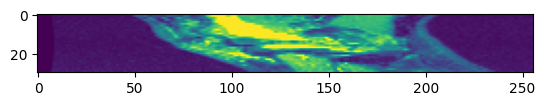

In [4]:
plt.imshow(mri[:,:,50])
plt.show()

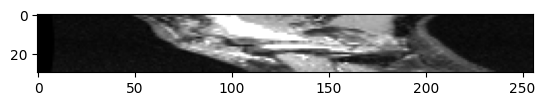

In [5]:
plt.imshow(mri[:,:,50], cmap='gray')
plt.show()

In [6]:
def preprocess_mri_data(mri_data):
    # Perform intensity normalization
    min_intensity = np.min(mri_data)
    max_intensity = np.max(mri_data)
    normalized_data = (mri_data - min_intensity) / (max_intensity - min_intensity)
    return normalized_data

def perform_segmentation(mri_data, num_clusters=2):
    # Preprocess mri data
    preprocess_mri = preprocess_mri_data(mri_data=mri_data)

    # Reshape MRI data to 1D array
    flattened_data = np.reshape(preprocess_mri, (-1, 1))

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(flattened_data)

    # Assign labels to segmented regions
    segmented_data = np.reshape(kmeans.labels_, preprocess_mri.shape)

    return segmented_data

In [7]:
preprocessed_mri = preprocess_mri_data(mri_data=mri)

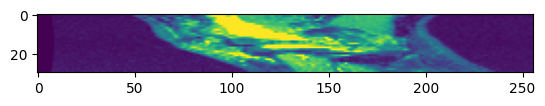

In [8]:
plt.imshow(preprocessed_mri[:,:,50])
plt.show()

In [9]:
segmented_mri = perform_segmentation(mri_data=mri)

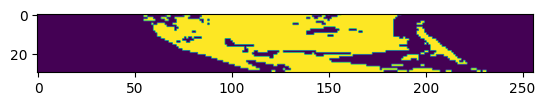

In [10]:
plt.imshow(segmented_mri[:,:,50])
plt.show()

In [28]:
type(segmented_mri)

numpy.ndarray

SimpleITK based Segmentation

In [23]:
import SimpleITK as sitk
import numpy as np
from helpers import *

sample_mri_path = 'MRNet-v1.0/train/axial/0002.npy'
mri_array = np.load(sample_mri_path)

In [24]:
mri_image = sitk.GetImageFromArray(mri_array)

In [25]:
explore_3D_array(mri_array)

interactive(children=(IntSlider(value=18, description='SLICE', max=37), Output()), _dom_classes=('widget-inter…

In [43]:
seg = mri_image > 200
thresh_img = sitk.LabelOverlay(mri_image, seg)
thresh_array = sitk.GetArrayFromImage(thresh_img)

In [44]:
explore_3D_array(thresh_array)

interactive(children=(IntSlider(value=18, description='SLICE', max=37), Output()), _dom_classes=('widget-inter…

In [34]:
seg = sitk.BinaryThreshold(mri_image, lowerThreshold=100, upperThreshold=400, insideValue=1, outsideValue=0)
thresh_img = sitk.LabelOverlay(mri_image, seg)
thresh_array = sitk.GetArrayFromImage(thresh_img)

In [35]:
explore_3D_array(thresh_array)

interactive(children=(IntSlider(value=18, description='SLICE', max=37), Output()), _dom_classes=('widget-inter…

In [42]:
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)
seg = otsu_filter.Execute(mri_image)
thresh_img = sitk.LabelOverlay(mri_image, seg)
thresh_array = sitk.GetArrayFromImage(thresh_img)
explore_3D_array(thresh_array)
print(otsu_filter.GetThreshold() )

interactive(children=(IntSlider(value=18, description='SLICE', max=37), Output()), _dom_classes=('widget-inter…

81.0


In [48]:
print(mri_array.shape)

(38, 256, 256)


In [74]:
seed = (128,128,18)
seg = sitk.Image(mri_image.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(mri_image)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, (3,3,3))
thresh_img = sitk.LabelOverlay(mri_image, seg)
thresh_array = sitk.GetArrayFromImage(thresh_img)
explore_3D_array(thresh_array)

interactive(children=(IntSlider(value=18, description='SLICE', max=37), Output()), _dom_classes=('widget-inter…

In [75]:
seed = (128,150,18)
seg = sitk.ConfidenceConnected(mri_image, seedList=[seed],
                                   numberOfIterations=1,
                                   multiplier=2.5,
                                   initialNeighborhoodRadius=1,
                                   replaceValue=1)
thresh_img = sitk.LabelOverlay(mri_image, seg)
thresh_array = sitk.GetArrayFromImage(thresh_img)
explore_3D_array(thresh_array)

interactive(children=(IntSlider(value=18, description='SLICE', max=37), Output()), _dom_classes=('widget-inter…

In [65]:
feature_img = sitk.GradientMagnitudeRecursiveGaussian(mri_image, sigma=.5)
speed_img = sitk.BoundedReciprocal(feature_img) # This is parameter free unlike the Sigmoid
thresh_array = sitk.GetArrayFromImage(speed_img)
explore_3D_array(thresh_array)

interactive(children=(IntSlider(value=18, description='SLICE', max=37), Output()), _dom_classes=('widget-inter…

In [76]:
fm_filter = sitk.FastMarchingBaseImageFilter()
fm_filter.SetTrialPoints([seed])
fm_filter.SetStoppingValue(1000)
fm_img = fm_filter.Execute(speed_img)
thresh_img = sitk.Threshold(fm_img,
                    lower=0.0,
                    upper=fm_filter.GetStoppingValue(),
                    outsideValue=fm_filter.GetStoppingValue()+1)
thresh_array = sitk.GetArrayFromImage(thresh_img)
explore_3D_array(thresh_array)

interactive(children=(IntSlider(value=18, description='SLICE', max=37), Output()), _dom_classes=('widget-inter…

In [68]:
seed = (128,128,18)
seg = sitk.Image(mri_image.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(mri_image)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, (3,3,3))

stats = sitk.LabelStatisticsImageFilter()
stats.Execute(mri_image, seg)

factor = 3.5
lower_threshold = stats.GetMean(1)-factor*stats.GetSigma(1)
upper_threshold = stats.GetMean(1)+factor*stats.GetSigma(1)
print(lower_threshold,upper_threshold)

-39.08644668179918 154.19259193319584


In [69]:
init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True)


In [71]:
lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
lsFilter.SetLowerThreshold(lower_threshold)
lsFilter.SetUpperThreshold(upper_threshold)
lsFilter.SetMaximumRMSError(0.02)
lsFilter.SetNumberOfIterations(1000)
lsFilter.SetCurvatureScaling(.5)
lsFilter.SetPropagationScaling(1)
lsFilter.ReverseExpansionDirectionOn()
ls = lsFilter.Execute(init_ls, sitk.Cast(mri_image, sitk.sitkFloat32))
print(lsFilter)

itk::simple::ThresholdSegmentationLevelSetImageFilter
  LowerThreshold: -39.0864
  UpperThreshold: 154.193
  MaximumRMSError: 0.02
  PropagationScaling: 1
  CurvatureScaling: 0.5
  NumberOfIterations: 1000
  ReverseExpansionDirection: 1
  ElapsedIterations: 1000
  RMSChange: 0.0570463
  Debug: 0
  NumberOfThreads: 8
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 1
  ActiveProcess: (none)



In [72]:
thresh_img = sitk.LabelOverlay(mri_image, ls>0)
thresh_array = sitk.GetArrayFromImage(thresh_img)
explore_3D_array(thresh_array)

interactive(children=(IntSlider(value=18, description='SLICE', max=37), Output()), _dom_classes=('widget-inter…